# Sentinel 2 Fractional Cover

## Code to query the Element84 STAC and drill out the Sentinel sites
Uses [Pixel Driller](https://pixeldriller.readthedocs.io/en/latest/) for the heavy lifting.

Star transects downloaded from the [Field Data Portal](https://field.jrsrp.com/)

In [ ]:
import pandas as pd
import numpy as np
import datetime
from pixdrill import drillpoints
from pixdrill import drill
from pixdrill import drillstats
from tqdm import tqdm  # Import tqdm for the progress bar

# Read the CSV file into a DataFrame
in_df = pd.read_csv('star_transects.csv')

# Get the relevant columns: FID, ref_x, ref_y, and obs_time
df = in_df[['FID', 'ref_x', 'ref_y', 'obs_time']]

# Define constants
crs_code = 4326  # EPSG code for WGS84 coordinate reference system
t_delta = datetime.timedelta(days=15)  # 15 days either side
site_shape = drillpoints.ROI_SHP_CIRCLE  # Define the extraction shape
site_radius = 50  # In meters

# Secondly, the STAC catalogue and raster assets of the STAC Items.
endpoint = "https://earth-search.aws.element84.com/v1"
collections = ['sentinel-2-l2a']
assets = ['blue', 'green', 'red', 'rededge1', 'rededge2', 'rededge3', 'nir', 'nir08', 'swir16', 'swir22', 'scl']

def user_median(array_info, item, pt):
    return [float(np.median(a_info.data.compressed() if np.ma.is_masked(a_info.data) else a_info.data)) for a_info in array_info]

def user_sclgood(array_info, item, pt):
    target_values = {4, 5, 6, 7, 11}
    stats = []
    for a_info in array_info:
        data = a_info.data.compressed() if np.ma.is_masked(a_info.data) else a_info.data
        count_good_pixels = np.isin(data, list(target_values)).sum()
        stats.append(count_good_pixels / len(data))
        
    return [float(stat) for stat in stats]

std_stats = [drillstats.STATS_MEAN, drillstats.STATS_STDEV, drillstats.STATS_COUNT]
user_stats = [("sclgood", user_sclgood)]

# Initialize an empty list for storing results
data = []

# Iterate over each row in the DataFrame with a progress bar
for _, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing Points"):
    longitude = row['ref_x']
    latitude = row['ref_y']
    
    # Parse the observation time string into a datetime object
    date = datetime.datetime.strptime(row['obs_time'], "%Y-%m-%dT%H:%M:%S")
    # Check that the date is greater than 23 June 2015
    if date < datetime.datetime(2015, 6, 23):
        continue

    # Create a Point object with information from the current row
    pt = drillpoints.Point(longitude, latitude, date, crs_code, t_delta, site_radius, site_shape)
    # Set the FID attribute of the Point object in pt.items
    pt.items['FID'] = row['FID']
    
    # Drill the point immediately
    drill.drill(
        [pt],  # Pass the single point in a list
        stac_endpoint=endpoint,
        raster_assets=assets,
        collections=collections,
        std_stats=std_stats,
        user_stats=user_stats
    )
    
    # Process the stats for this point
    for item_id, item_stats in pt.stats.get_stats().items():
        scl_percent = item_stats['sclgood'][-1]
        if scl_percent < 1.0:
            continue
        fid = pt.items['FID']
        sat_date = datetime.datetime.strptime(item_id.split('_')[2], "%Y%m%d").isoformat()
        mean_values = item_stats[drillstats.STATS_MEAN]
        stdev_values = item_stats[drillstats.STATS_STDEV]
        count_values = item_stats[drillstats.STATS_COUNT]
        data.append([fid, item_id, sat_date, mean_values, stdev_values, count_values])

out_df = pd.DataFrame(data, columns=['FID', 'item_id', 'sat_date', 'means', 'stdevs', 'counts'])
# Save the DataFrame
out_df.to_pickle('s2sr_df.pkl')
# Print the DataFrame
print(out_df)
# Print the number of rows in the DataFrame
print(f"Number of rows: {len(out_df)}")

# Join the dataframes on the FID column noting that the out_df will be on the left and multiple rows will be returned
joined_df = out_df.merge(in_df, on='FID', how='left')
# Save the joined DataFrame
joined_df.to_pickle('s2sr_tern_joined.pkl')

## Fractional Cover Calibration Steps

In [1]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Use dark style for plots
plt.style.use('dark_background')


print("TensorFlow v"+tf.__version__)
print(tf.test.gpu_device_name())


def fractionalCoverSatView(df):
    """
    Calculate fractional cover as viewed from a satellite based on intercept data from a DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing the necessary columns:
        - 'num_points', 'unoccluded', 'over_b', 'over_d', 'over_g', 'crn',
          'mid_b', 'mid_g', 'mid_d', 'dead', 'litter', 'crust', 'dist',
          'rock', 'green', 'crypto'.

    Returns:
    tuple of np.ndarray: Six NumPy arrays, each representing one of the calculated cover metrics.
    """
    
    totalPVCover_list = []
    totalNPVCover_list = []
    totalBareCover_list = []
    totalCryptoCover_list = []
    satPersistentGreen_list = []
    persistentNPVFraction_list = []

    for _, row in df.iterrows():
        nTotal = row['num_points']
        nUnoccluded = row['unoccluded']
        
        # Canopy Layer
        nCanopyBranch = row['over_b'] * nTotal / 100.0
        nCanopyDead = row['over_d'] * nTotal / 100.0
        nCanopyGreen = row['over_g'] * nTotal / 100.0
        
        # Midstory Layer
        nMidBranch = row['mid_b'] * nTotal / 100.0
        nMidGreen = row['mid_g'] * nTotal / 100.0
        nMidDead = row['mid_d'] * nTotal / 100.0
        
        # Ground Layer
        nGroundDeadLitter = (row['dead'] + row['litter']) * nUnoccluded / 100.0
        nGroundCrustDistRock = (row['crust'] + row['dist'] + row['rock']) * nUnoccluded / 100.0
        nGroundGreen = row['green'] * nUnoccluded / 100.0
        nGroundCrypto = row['crypto'] * nUnoccluded / 100.0
        
        # Calculations
        canopyFoliageProjectiveCover = nCanopyGreen / (nTotal - nCanopyBranch)
        canopyDeadProjectiveCover = nCanopyDead / (nTotal - nCanopyBranch)
        canopyBranchProjectiveCover = nCanopyBranch / nTotal * (1.0 - canopyFoliageProjectiveCover - canopyDeadProjectiveCover)
        canopyPlantProjectiveCover = (nCanopyGreen+nCanopyDead + nCanopyBranch) / nTotal
        
        midFoliageProjectiveCover = nMidGreen / nTotal
        midDeadProjectiveCover = nMidDead / nTotal
        midBranchProjectiveCover = nMidBranch / nTotal
        midPlantProjectiveCover = (nMidGreen + nMidDead + nMidBranch) / nTotal
        
        satMidFoliageProjectiveCover = midFoliageProjectiveCover * (1 - canopyPlantProjectiveCover)
        satMidDeadProjectiveCover = midDeadProjectiveCover * (1 - canopyPlantProjectiveCover)
        satMidBranchProjectiveCover = midBranchProjectiveCover * (1 - canopyPlantProjectiveCover)
        
        groundPVCover = nGroundGreen / nUnoccluded
        groundNPVCover = nGroundDeadLitter / nUnoccluded
        groundBareCover = nGroundCrustDistRock / nUnoccluded
        groundCryptoCover = nGroundCrypto / nUnoccluded
        groundTotalCover = (nGroundGreen + nGroundDeadLitter + nGroundCrustDistRock) / nUnoccluded
        
        satGroundPVCover = groundPVCover * (1 - midPlantProjectiveCover) * (1 - canopyPlantProjectiveCover)
        satGroundNPVCover = groundNPVCover * ( 1- midPlantProjectiveCover) * (1 - canopyPlantProjectiveCover)
        satGroundBareCover = groundBareCover * (1 - midPlantProjectiveCover) * (1 - canopyPlantProjectiveCover)
        satGroundCryptoCover = groundCryptoCover * (1 - midPlantProjectiveCover) * (1 - canopyPlantProjectiveCover)
        
        totalPVCover = canopyFoliageProjectiveCover + satMidFoliageProjectiveCover + satGroundPVCover
        totalNPVCover = (canopyDeadProjectiveCover + canopyBranchProjectiveCover +
                         satMidDeadProjectiveCover + satMidBranchProjectiveCover + satGroundNPVCover)
        totalBareCover = satGroundBareCover
        totalCryptoCover = satGroundCryptoCover
        
        satPersistentGreen = canopyFoliageProjectiveCover + satMidFoliageProjectiveCover
        persistentNPVFraction = (canopyDeadProjectiveCover + canopyBranchProjectiveCover +
                                 satMidDeadProjectiveCover + satMidBranchProjectiveCover)

        totalPVCover_list.append(totalPVCover)
        totalNPVCover_list.append(totalNPVCover)
        totalBareCover_list.append(totalBareCover)
        totalCryptoCover_list.append(totalCryptoCover)
        satPersistentGreen_list.append(satPersistentGreen)
        persistentNPVFraction_list.append(persistentNPVFraction)

    return (
        np.array(totalPVCover_list),
        np.array(totalNPVCover_list),
        np.array(totalBareCover_list),
        np.array(totalCryptoCover_list),
        np.array(satPersistentGreen_list),
        np.array(persistentNPVFraction_list),
    )


2025-02-13 14:35:48.197848: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-13 14:35:48.723298: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow v2.12.1



## Load the Sentinel 2 data associated with the Star Transect sites

This opens the dataframe, filters by SCL, selects a maximum of two closest dates, and applies the function to recover the fractional cover values from the field data.

In [ ]:



# Read s2sr_tern_joined.pkl as a pandas DataFrame
df = pd.read_pickle('s2sr_tern_joined.pkl')
# Remove all the rows where the last element (SCL) in the means column is not 5
df = df[df['means'].apply(lambda x: x[-1] == 5)]
# Remove all the rows where there is no field data
df = df.dropna(subset=['unoccluded', 'over_b', 'over_d', 'over_g', 'crn', 'mid_b', 'mid_g', 'mid_d', 'dead', 'litter', 'crust', 'dist', 'rock', 'green', 'crypto'])
# Calculate a new column called days_diff which is the difference between the obs_time and the sat_date strings
df['days_diff'] = (pd.to_datetime(df['obs_time']) - pd.to_datetime(df['sat_date'])).dt.days
# Print the number of rows
print(df.shape[0])
# Select the closest 2 observations for each FID
# df = df.sort_values('days_diff').groupby('FID').head(2)


# Select all the observations  for the two closest dates for each FID
# This is picking up the overlaps between tiles and processing versions
df = df.sort_values(['FID', 'days_diff'])
# Function to get the closest dates
def get_closest_dates(sub_df):
    # Select the closest two dates for each FID
    closest_dates = sub_df.nsmallest(2, 'days_diff', keep='all')['sat_date'].unique()
    return sub_df[sub_df['sat_date'].isin(closest_dates)]


df = df.groupby('FID', group_keys=False).apply(get_closest_dates)


# Print the number of rows
print(df.shape[0])
# Find the unique values of the FID column
FIDs = df['FID'].unique()
# Print the counts of the unique values ordered from the most to the least frequent
print(df['FID'].value_counts())
# Add the counts to the DataFrame
df['FID_counts'] = df['FID'].map(df['FID'].value_counts())


# Calculate fractional cover as viewed from a satellite based on intercept data   
totalPVCover,totalNPVCover,totalBareCover,totalCryptoCover,satPersistentGreen,persistentNPVFraction = fractionalCoverSatView(df)
      
# Extract the Sentinel 2 reflectance from the means column of the DataFrame
refData = df['means'].apply(pd.Series).values
# Drop the last column (SCL)
refData = refData[:, :-1] / 10000
# Extract the weights from the FID_counts column of the DataFrame
weights = 1/df['FID_counts'].values

print(f"Number of sites: {len(totalPVCover)}")




11450


/tmp/ipykernel_1902325/1943804249.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('FID', group_keys=False).apply(get_closest_dates)


2966
FID
star_transects.fid-35735e87_1942a663648_-6c73    8
star_transects.fid-35735e87_1942a663648_-712d    8
star_transects.fid-35735e87_1942a663648_-6e9e    8
star_transects.fid-35735e87_1942a663648_-6dbc    8
star_transects.fid-35735e87_1942a663648_-6e9a    8
                                                ..
star_transects.fid-35735e87_1942a663648_-7125    1
star_transects.fid-35735e87_1942a663648_-7137    1
star_transects.fid-35735e87_1942a663648_-714b    1
star_transects.fid-35735e87_1942a663648_-7087    1
star_transects.fid-35735e87_1942a663648_-708f    1
Name: count, Length: 1302, dtype: int64
Number of sites: 2966


In [4]:
refData[0]

array([0.09703232, 0.15777778, 0.25356162, 0.27813   , 0.28772   ,
       0.30116333, 0.32598788, 0.32358667, 0.48628333, 0.41627667])

#### Have a look at the reflectance spread for a single field site

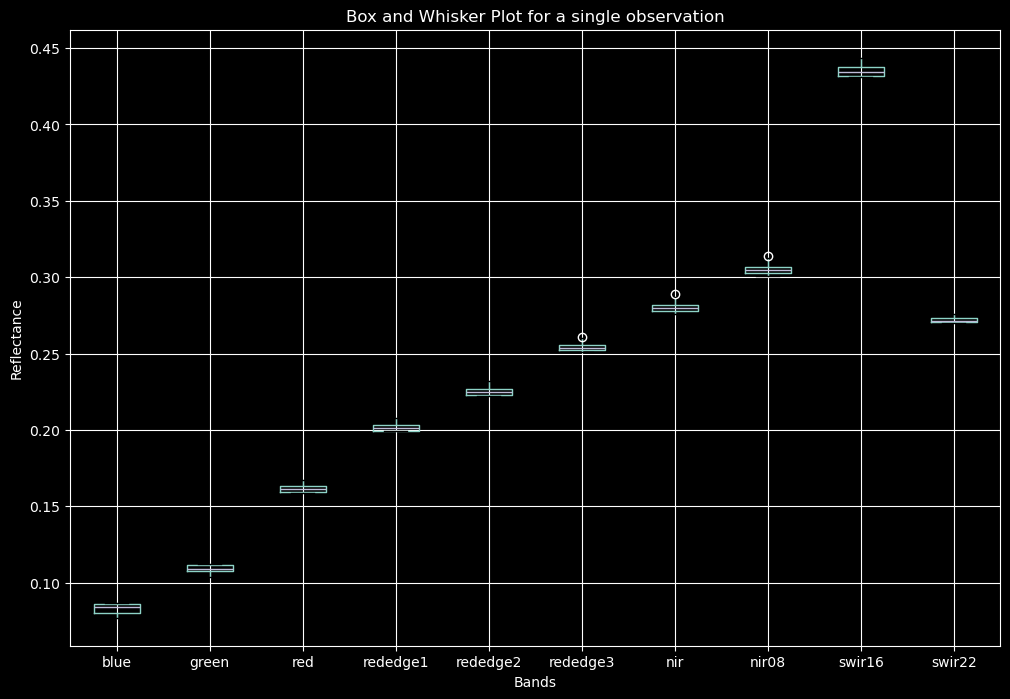

In [5]:
# Plot the number of observations per FID
# Select rows where FID = star_transects.fid-35735e87_1942a663648_-7231 and sat_date = 2019-06-01T00:00:00
df_means = df[(df['FID'] == 'star_transects.fid-35735e87_1942a663648_-6e9a')]['means'].apply(pd.Series)
df_means.columns = ['blue', 'green', 'red', 'rededge1', 'rededge2', 'rededge3', 'nir', 'nir08', 'swir16', 'swir22', 'scl']
# Drop SCL column
df_means = df_means.drop(columns='scl')
# Divide by 10000 to get reflectance
df_means = df_means / 10000
# Plotting
plt.figure(figsize=(12, 8))
df_means.boxplot()
plt.title('Box and Whisker Plot for a single observation')
plt.ylabel('Reflectance')
plt.xlabel('Bands')
plt.show()


### Plot the Green field data

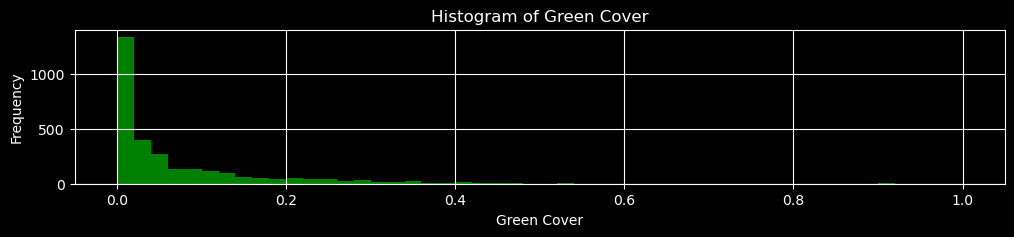

In [6]:
plt.figure(figsize=(12, 2))
# Plot a histogram of cryptogam cover
plt.hist(totalPVCover, bins=50, color='green')
plt.title('Histogram of Green Cover')
plt.xlabel('Green Cover')
plt.ylabel('Frequency')
plt.grid()

## Iteration 1 - Minimal Prediction to assign crypto and detect outliers
The next problem to address is field labeling issues.  
First, cryptogram (or biological soil crusts) are not assigned a "colour" and we need to decide whether to treat them as green or non green. We do this by doing a rough model fit, and then testing where the cryptogram component for each sit best fits.  

For this model, we don't apply a sum to one as the crypto is missing.

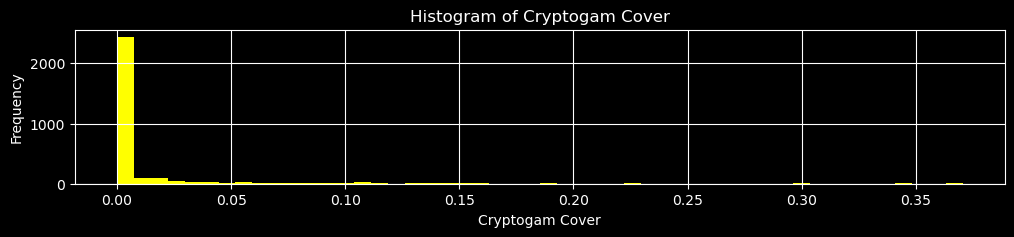

In [19]:
plt.figure(figsize=(12, 2))
# Plot a histogram of cryptogam cover
plt.hist(totalCryptoCover, bins=50, color='yellow')
plt.title('Histogram of Cryptogam Cover')
plt.xlabel('Cryptogam Cover')
plt.ylabel('Frequency')
plt.grid()

In [20]:
# Set up the data for training
train_labels = np.transpose([totalBareCover, totalPVCover, totalNPVCover])
train_dataset = refData.copy()

model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', kernel_constraint=tf.keras.constraints.max_norm(1), input_shape=[train_dataset.shape[1]]),
    tf.keras.layers.Dense(256, activation='relu', kernel_constraint=tf.keras.constraints.max_norm(1)),
    tf.keras.layers.Dense(256, activation='relu', kernel_constraint=tf.keras.constraints.max_norm(1)),
    tf.keras.layers.Dense(3)
])

model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

# Custom callback for tqdm progress bar
class TQDMProgressBar(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.progress_bar = tqdm(total=self.params['epochs'], desc="Training Progress", unit="epoch")

    def on_epoch_end(self, epoch, logs=None):
        self.progress_bar.update(1)

    def on_train_end(self, logs=None):
        self.progress_bar.close()

# Fit the Model
history = model.fit(train_dataset, train_labels,
                    epochs=2000,
                    validation_split=0.5,
                    verbose=0,
                    shuffle=True,
                    batch_size=8192,
                    callbacks=[TQDMProgressBar()])

allPredictions = model.predict(train_dataset)
predNongreenCover = allPredictions[:, 2]
predGreenCover = allPredictions[:, 1]
predBareCover = allPredictions[:, 0]


/home/ubuntu/miniforge3/envs/tensorflow/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1739161630.847616 1547820 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1739161630.849153 1547820 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1739161630.850208 1547820 cu

Training Progress:   0%|          | 0/2000 [00:00<?, ?epoch/s]I0000 00:00:1739161633.079405 1585467 service.cc:146] XLA service 0x7066e8009710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739161633.079433 1585467 service.cc:154]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-02-10 04:27:13.106667: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-10 04:27:13.229649: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90201
I0000 00:00:1739161633.802763 1585467 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Training Progress: 100%|██████████| 2000/2000 [01:24<00:00, 23.80epoch/s]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


### Guess the cryptogram class by assigning to the class that gives the best fit
Dodgy as, but I can't think of a better method

In [21]:
# Assign the crypto to the class that improves the error the most    
greenError  = predGreenCover - totalPVCover
nongreenError = predNongreenCover-totalNPVCover

cryptoNongreenIDX = (np.abs(nongreenError) >= np.abs(nongreenError-totalCryptoCover))
cryptoGreenIDX = (np.abs(nongreenError) < np.abs(nongreenError-totalCryptoCover))
totalPVCover[cryptoGreenIDX] = totalPVCover[cryptoGreenIDX] + totalCryptoCover[cryptoGreenIDX]
totalNPVCover[cryptoNongreenIDX] = totalNPVCover[cryptoNongreenIDX] + totalCryptoCover[cryptoNongreenIDX]


print("Nongreen crypto samples = %f" %np.sum(cryptoNongreenIDX))
print("Green crypto samples = %f" %np.sum(cryptoGreenIDX))



Nongreen crypto samples = 2562.000000
Green crypto samples = 404.000000


### Remove potential outliers
There are some outliers in the field data. These seem to be some of the early CHAT sites and also those sites where the groundcover has changes significantly in the days between the measurement.

We detect these by finding those sites where the prediction error is more than 3 standard deviations from zero.

Retaining 2926 Sites


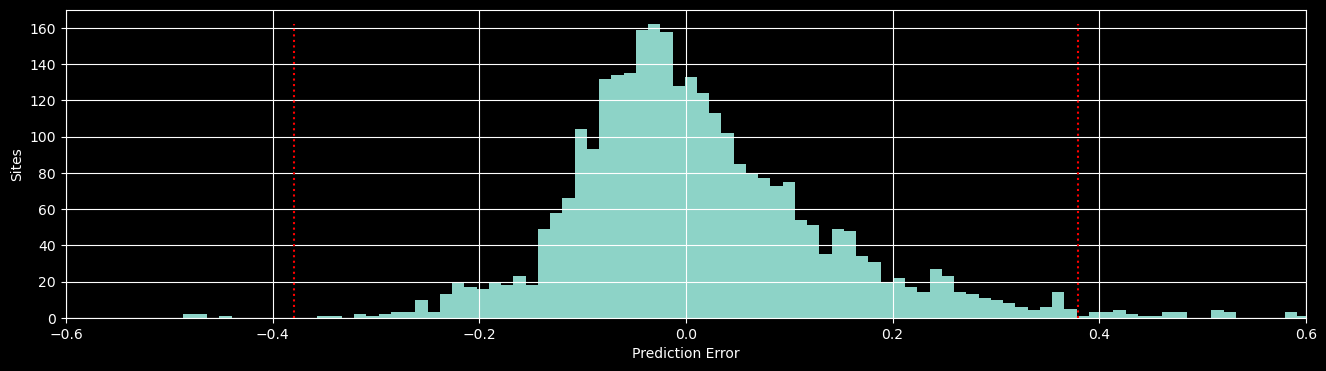

In [22]:
# Find any wild outliers - Typically early CHAT sites or sites where rainfall or grazing rapidly changed the surface
barePredictionError= totalBareCover-predBareCover
anomalyCutoff = np.std(barePredictionError) * 3.0
isNotOutlierIDX = np.where(np.abs(barePredictionError) < anomalyCutoff)
print(f'Retaining {len(isNotOutlierIDX[0])} Sites')
totalBareCover = np.array(totalBareCover)[isNotOutlierIDX]
totalPVCover = np.array(totalPVCover)[isNotOutlierIDX]
totalNPVCover = np.array(totalNPVCover)[isNotOutlierIDX]
persistentNPVFraction = np.array(persistentNPVFraction)[isNotOutlierIDX]
satPersistentGreen = np.array(satPersistentGreen)[isNotOutlierIDX]
refData = refData[isNotOutlierIDX]

# Plot the cutoffs
plt.figure(figsize=(16,4))
histData = plt.hist(barePredictionError,bins=100)
plt.xlabel('Prediction Error')
plt.ylabel('Sites')
plt.plot([-anomalyCutoff,-anomalyCutoff],[0,np.max(histData[0])],':r')
plt.plot([anomalyCutoff,anomalyCutoff],[0,np.max(histData[0])],':r')
plt.xlim([-0.6,0.6])
plt.grid()
#plt.savefig('../paper/anomaly.png', bbox_inches='tight', facecolor='w')

## Equal Sampling Weighting
Because the samples are not uniformly distributed across the cover space, we set up a histogram based weighting function to make sure those rare sites still contribute to the model.

In the Landsat model, the histogram has 10 bins and the dodgy polynomial fudge is not required as there is a reasonable spread of green sites

0.5925, -0.1716, 0.0903
0.9146, -0.1981, 0.0120
0.6285, -0.9036, 0.4444


Text(0, 0.5, 'Weight')

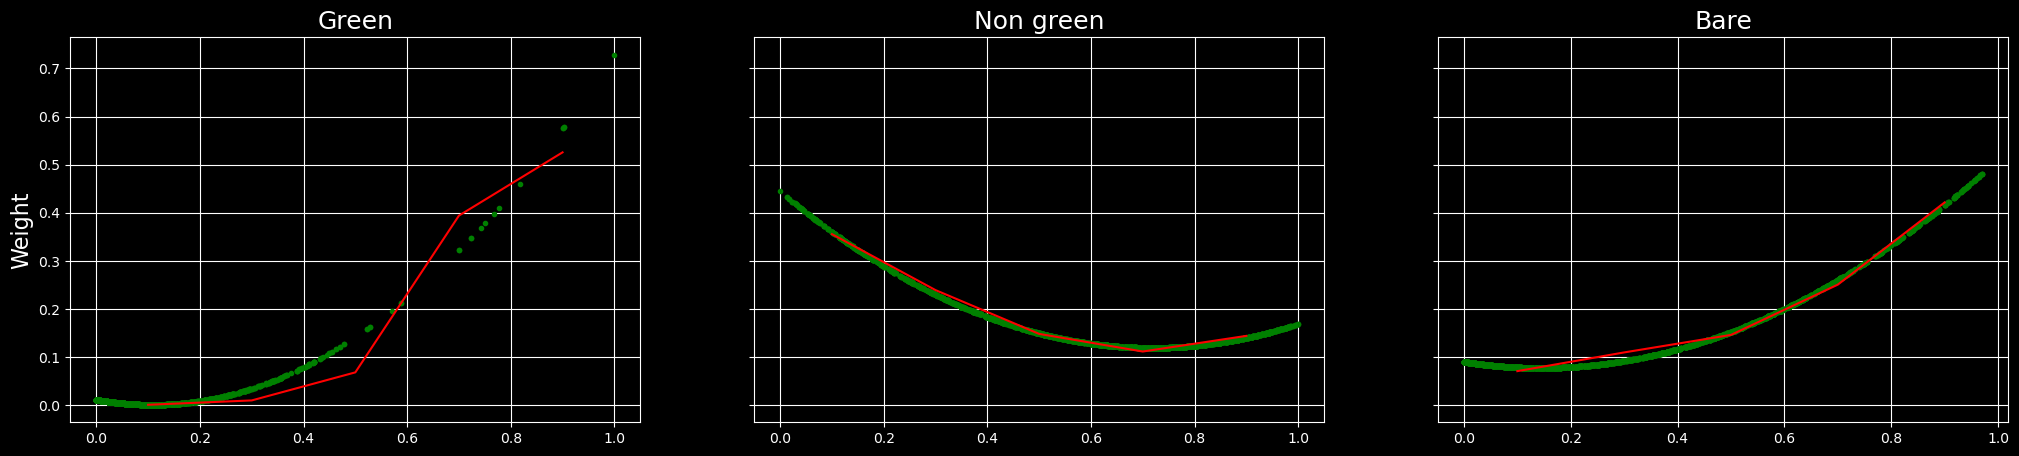

In [23]:
# Weighting by number of points
histoB = np.histogram(totalBareCover,bins=5,range=[0,1])
histoNormB=histoB[0].sum()/histoB[0]
histoNormB /= histoNormB.sum()
bareCoeffs = np.polyfit((histoB[1][1:]+histoB[1][:-1])/2,histoNormB,2)
bareWeights = np.polyval(bareCoeffs,totalBareCover)
if bareWeights.min() < histoNormB.min():
    bareCoeffs[-1] = bareCoeffs[-1] + (histoNormB.min()-bareWeights.min())
    bareWeights = np.polyval(bareCoeffs,totalBareCover)
print(", ".join([f"{coeff:.4f}" for coeff in bareCoeffs]))


# Weighting by number of points
histoG = np.histogram(totalPVCover,bins=5,range=[0,1])
histoNormG=histoG[0].sum()/histoG[0]
histoNormG /= histoNormG.sum()
greenCoeffs = np.polyfit((histoG[1][1:]+histoG[1][:-1])/2,histoNormG,2)
greenWeights = np.polyval(greenCoeffs,totalPVCover)
if greenWeights.min() < histoNormG.min():
    greenCoeffs[-1] = greenCoeffs[-1] + (histoNormG.min()-greenWeights.min())
    greenWeights = np.polyval(greenCoeffs,totalPVCover)
print(", ".join([f"{coeff:.4f}" for coeff in greenCoeffs]))

# Weighting by number of points
histoN = np.histogram(totalNPVCover,bins=5,range=[0,1])
histoNormN=histoN[0].sum()/histoN[0]
histoNormN /= histoNormN.sum()
nonGreenCoeffs = np.polyfit((histoN[1][1:]+histoN[1][:-1])/2,histoNormN,2)
nonGreenWeights = np.polyval(nonGreenCoeffs,totalNPVCover)
if nonGreenWeights.min() < histoNormN.min():
    nonGreenCoeffs[-1] = nonGreenCoeffs[-1] + (histoNormN.min()-nonGreenWeights.min())
    nonGreenWeights = np.polyval(nonGreenCoeffs,totalNPVCover)
print(", ".join([f"{coeff:.4f}" for coeff in nonGreenCoeffs]))

sampleWeights = np.transpose([bareWeights,greenWeights,nonGreenWeights])

# Initialise the 1 row 3 column plot
f, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(25,5),sharey=True)
# Plot the three fractions
ax1.plot(totalPVCover,greenWeights,'g.',(histoG[1][1:]+histoG[1][:-1])/2,histoNormG, 'r-')
ax2.plot(totalNPVCover,nonGreenWeights,'g.',(histoN[1][1:]+histoN[1][:-1])/2,histoNormN, 'r-')
ax3.plot(totalBareCover,bareWeights,'g.',(histoB[1][1:]+histoB[1][:-1])/2,histoNormB, 'r-')
# Grids
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
# Titles and Labels
ax1.set_title('Green', fontsize=18)
ax2.set_title('Non green', fontsize=18)
ax3.set_title('Bare', fontsize=18)
ax1.set_ylabel('Weight', fontsize=16)
#plt.savefig('../paper/weights.png', bbox_inches='tight')

### Build a weighted Loss Function using these coefficients



In [24]:
def histogramWeightedLoss(y_true, y_pred):
    # Calculate polynomial weights for each component of y_true
    yWeights = tf.transpose([
        tf.math.polyval([0.5925, -0.1716, 0.0903], y_true[:, 0]),
        tf.math.polyval([0.9146, -0.1981, 0.0120], y_true[:, 1]),
        tf.math.polyval([0.6285, -0.9036, 0.4444], y_true[:, 2])
    ])
    
    # Compute the different components of the loss
    unmixingError = tf.reduce_mean(tf.abs(y_true * yWeights - y_pred * yWeights), axis=-1)
    negativityError = tf.reduce_mean(-y_pred * tf.cast(tf.less(y_pred, 0), tf.float32), axis=1)
    sum2oneError = 0.005 * tf.abs(tf.reduce_sum(y_pred, axis=1) - 1.0)

    # Combine all components into the final loss
    loss = unmixingError + sum2oneError + negativityError
    
    return loss


## Build and Train the model

In [40]:
train_dataset[0]

array([0.09703232, 0.15777778, 0.25356162, 0.27813   , 0.28772   ,
       0.30116333, 0.32598788, 0.32358667, 0.48628333, 0.41627667])

/home/ubuntu/miniforge3/envs/tensorflow/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 256)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,963 (785.01 KB)

 Trainable params: 200,963 (785.01 KB)

 Non-trainable params: 0 (0.00 B)

Training Progress:  10%|█         | 1019/10000 [00:50<06:38, 22.54epoch/s]

Training Progress:  18%|█▊        | 1782/10000 [01:24<05:59, 22.87epoch/s]


Epoch 1783: ReduceLROnPlateau reducing learning rate to 0.0009500000451225787.


Training Progress:  23%|██▎       | 2283/10000 [01:46<05:35, 22.99epoch/s]


Epoch 2283: ReduceLROnPlateau reducing learning rate to 0.0009025000152178108.


Training Progress:  28%|██▊       | 2781/10000 [02:08<05:20, 22.54epoch/s]


Epoch 2783: ReduceLROnPlateau reducing learning rate to 0.0008573750033974647.


Training Progress:  33%|███▎      | 3282/10000 [02:30<05:08, 21.81epoch/s]


Epoch 3283: ReduceLROnPlateau reducing learning rate to 0.0008145062311086804.


Training Progress:  35%|███▌      | 3540/10000 [02:41<04:55, 21.86epoch/s]

Epoch 3540: early stopping
Restoring model weights from the end of the best epoch: 1540.


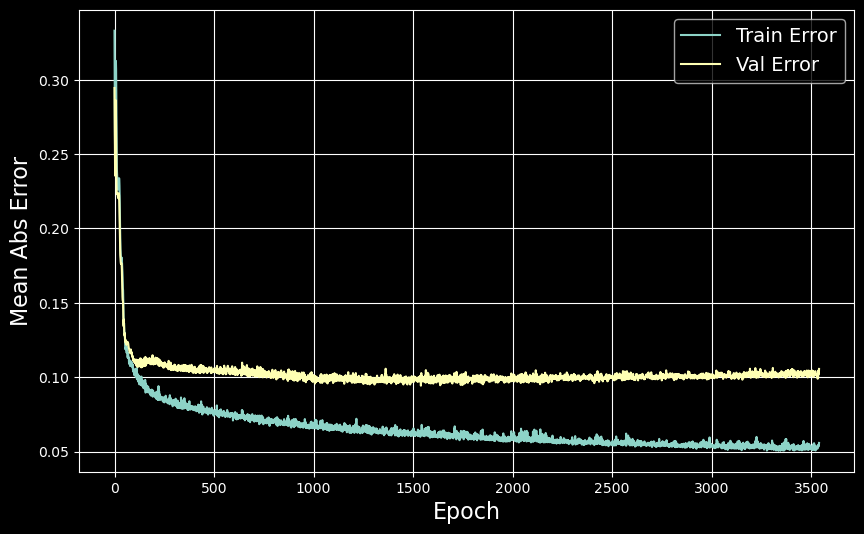

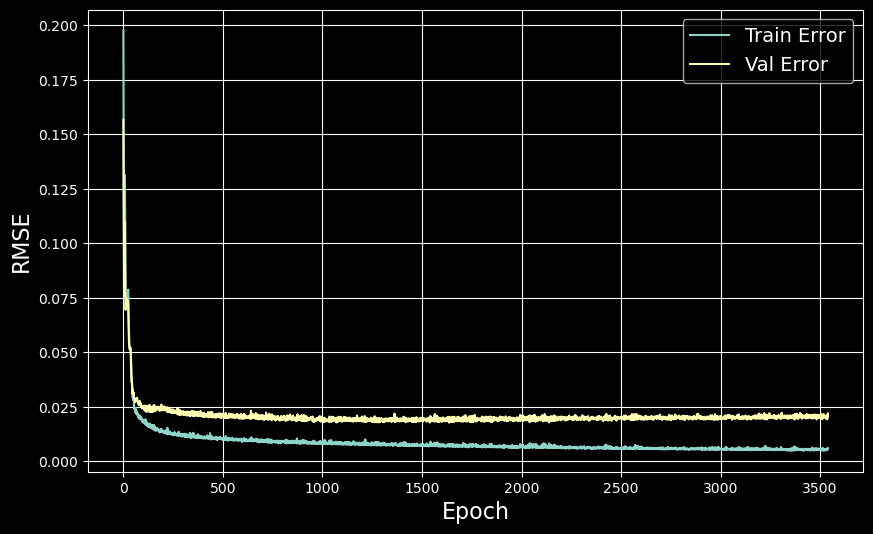

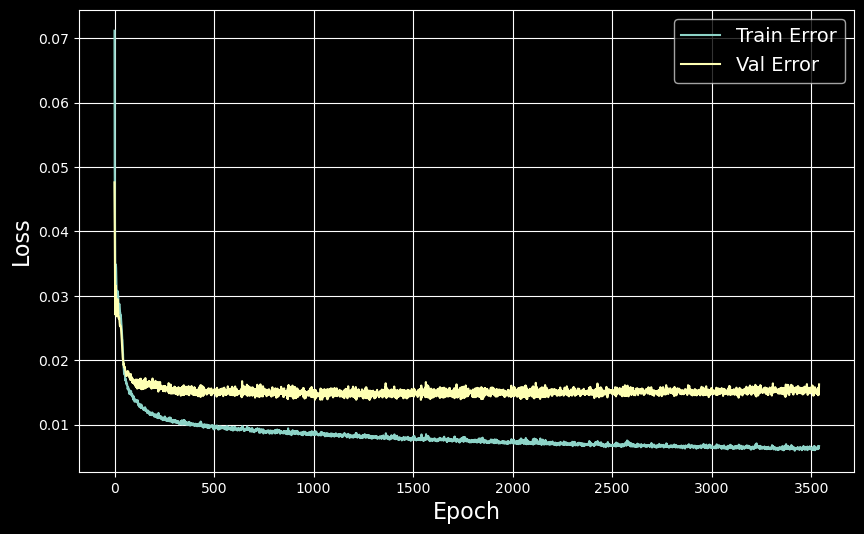

In [34]:
# Build the training Labels
train_labels = np.transpose([totalBareCover,totalPVCover,totalNPVCover])
train_dataset = refData.copy()

model = tf.keras.Sequential([
tf.keras.layers.Dense(256, activation='relu',kernel_constraint=tf.keras.constraints.max_norm(1),input_shape=[train_dataset.shape[1]]),
tf.keras.layers.Dropout(0.25),
tf.keras.layers.Dense(256, activation='relu', kernel_constraint=tf.keras.constraints.max_norm(1)),
tf.keras.layers.Dropout(0.25),
tf.keras.layers.Dense(256, activation='relu',kernel_constraint=tf.keras.constraints.max_norm(1)),
tf.keras.layers.Dropout(0.25),
tf.keras.layers.Dense(256, activation='relu',kernel_constraint=tf.keras.constraints.max_norm(1)),
tf.keras.layers.Dropout(0.25),
tf.keras.layers.Dense(3)
])


model.compile(loss=histogramWeightedLoss,
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            metrics=['mean_absolute_error', 'mean_squared_error']) 
model.summary()

# Fit the Model 



history = model.fit(train_dataset, train_labels,
                    epochs=10000,
                    validation_split = 0.5,
                    verbose=0,
                    shuffle=True,
                    batch_size=65536,
                    callbacks=[TQDMProgressBar(),
                    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2000,restore_best_weights=True),
                    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.95,patience=500, verbose=1, min_lr=0.0001)])
print('\n')

# Display the training history
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(10,6))
  plt.xlabel('Epoch', fontsize=16)
  plt.ylabel('Mean Abs Error', fontsize=16)
  plt.plot(hist['epoch'], hist['mean_absolute_error'],label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],label = 'Val Error')
  plt.grid(True)
  plt.legend(fontsize=14)
  #plt.savefig('../paper/trainingMAE.png', bbox_inches='tight', facecolor='w')

  plt.figure(figsize=(10,6))
  plt.xlabel('Epoch', fontsize=16)
  plt.ylabel('RMSE', fontsize=16)
  plt.plot(hist['epoch'], hist['mean_squared_error'],label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],label = 'Val Error')
  plt.grid(True)
  plt.legend(fontsize=14)
  #plt.savefig('../paper/trainingMSE.png', bbox_inches='tight', facecolor='w')

  plt.figure(figsize=(10,6))
  plt.xlabel('Epoch', fontsize=16)
  plt.ylabel('Loss', fontsize=16)
  plt.plot(hist['epoch'], hist['loss'],label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'],label = 'Val Error')
  plt.grid(True)
  plt.legend(fontsize=14)
  #plt.savefig('../paper/trainingLoss.png', bbox_inches='tight', facecolor='w')


plot_history(history)

### Prediction Plots

67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Green RMSE = 0.080989
Non Green RMSE = 0.126945
Bare RMSE = 0.114394

Green MAE = 0.048448
Non Green MAE = 0.090800
Bare MAE = 0.082971

Min Bare = 0.047932
Min Green = 0.015755
Min NonGreen = 0.061516


(0.0, 1.0)

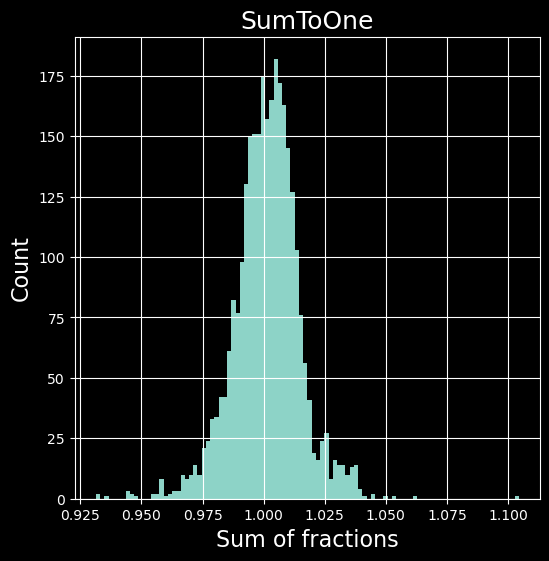

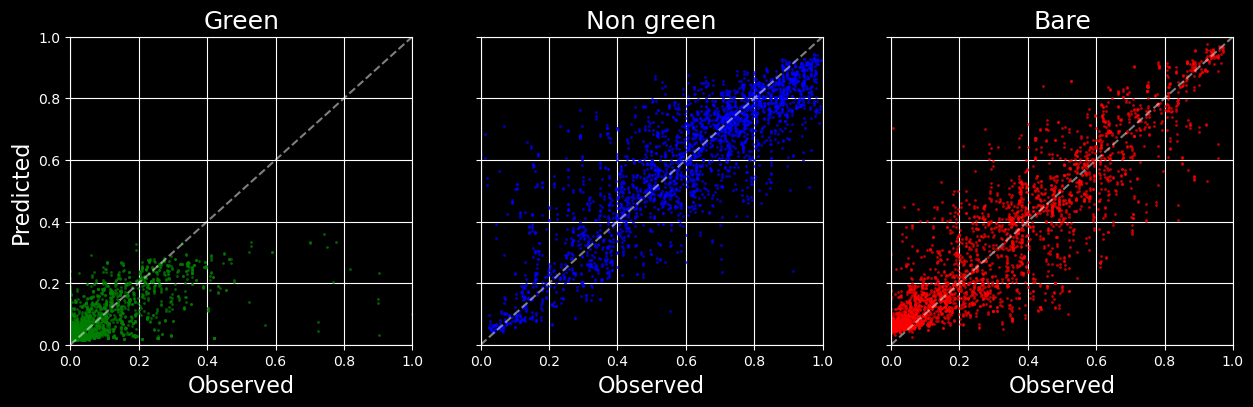

In [35]:
# Predict
allLabels = train_labels
allPredictions = model.predict(train_dataset)

predNongreenCover=allPredictions[:,2]
predGreenCover=allPredictions[:,1]
predBareCover=allPredictions[:,0]
totalSum = predNongreenCover+predGreenCover+predBareCover

# Print some RMSE values
print( "\nGreen RMSE = %f" % np.sqrt(np.mean((totalPVCover-predGreenCover)**2)))
print( "Non Green RMSE = %f" % np.sqrt(np.mean((totalNPVCover-predNongreenCover)**2)))
print( "Bare RMSE = %f" % np.sqrt(np.mean((totalBareCover-predBareCover)**2)))
# Print some MAE values
print( "\nGreen MAE = %f" % np.mean(np.abs(totalPVCover-predGreenCover)))
print( "Non Green MAE = %f" % np.mean(np.abs(totalNPVCover-predNongreenCover)))
print( "Bare MAE = %f" % np.mean(np.abs(totalBareCover-predBareCover)))
# Print the minimum values
print( "\nMin Bare = %f" % np.percentile(predBareCover,1))
print( "Min Green = %f" % np.percentile(predGreenCover,1))
print( "Min NonGreen = %f" % np.percentile(predNongreenCover,1))


# Setup the sum to one histogram
fig = plt.figure(figsize=(6,6))
plt.hist(totalSum, bins=100)
plt.title('SumToOne', fontsize=18)
plt.grid(True)
plt.xlabel('Sum of fractions', fontsize=16)
plt.ylabel('Count', fontsize=16)
#plt.savefig('../paper/fcSum2one.png', bbox_inches='tight',facecolor='w')

# Initialise the 1 row 3 column plot for each fraction
f, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15,4),sharey=True)
# Plot the three fractions
ax1.plot(totalPVCover,predGreenCover, 'go',alpha=0.75,markeredgewidth=0.0, markersize=2)
ax2.plot(totalNPVCover,predNongreenCover, 'bo',alpha=0.75,markeredgewidth=0.0, markersize=2)
ax3.plot(totalBareCover,predBareCover, 'ro',alpha=0.75,markeredgewidth=0.0, markersize=2)
# Plot 1:1 lines
ax1.plot([0, 1], [0, 1], 'w--',alpha=0.5)
ax2.plot([0, 1], [0, 1], 'w--',alpha=0.5)
ax3.plot([0, 1], [0, 1], 'w--',alpha=0.5)
# Grids
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
# Titles and Labels
ax1.set_title('Green', fontsize=18)
ax2.set_title('Non green', fontsize=18)
ax3.set_title('Bare', fontsize=18)
ax1.set_xlabel('Observed', fontsize=16)
ax2.set_xlabel('Observed', fontsize=16)
ax3.set_xlabel('Observed', fontsize=16)
ax1.set_ylabel('Predicted', fontsize=16)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax3.set_xlim([0, 1])
ax3.set_ylim([0, 1])
#f.savefig('../paper/fcCalibration.png', bbox_inches='tight',facecolor='w')



### Save the model

In [36]:
import datetime
import tensorflow as tf

# Define a directory to save the model
model_dir = './s2_fc_model'

# Save the model in the SavedModel format
model.export(model_dir)

print("Saved model in SavedModel format at:", model_dir)

# Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_saved_model(model_dir)
tflite_model = converter.convert()

# Save the TFLite model
tflite_model_path = './s2_fc_model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print("TFLite model saved at:", tflite_model_path)

# Now save the model as a .keras model not a legacy .h5 model
model.save('./s2_fc_model.keras')






INFO:tensorflow:Assets written to: ./s2_fc_model/assets


INFO:tensorflow:Assets written to: ./s2_fc_model/assets


Saved artifact at './s2_fc_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 10), dtype=tf.float32, name='keras_tensor_26')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  123588908210064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123588908209680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123588909158608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123588909156688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123588909157264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123588909155344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123588909154768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123588909154576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123588909157648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123588909161488: TensorSpec(shape=(), dtype=tf.resource, name=None)
Saved model in SavedModel

W0000 00:00:1739165429.084356 1547820 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1739165429.084380 1547820 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.


TFLite model saved at: ./s2_fc_model.tflite


2025-02-10 05:30:29.084545: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: ./s2_fc_model
2025-02-10 05:30:29.085347: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-02-10 05:30:29.085361: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: ./s2_fc_model
2025-02-10 05:30:29.091502: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-02-10 05:30:29.133911: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: ./s2_fc_model
2025-02-10 05:30:29.144675: I tensorflow/cc/saved_model/loader.cc:462] SavedModel load for tags { serve }; Status: success: OK. Took 60133 microseconds.


## SHAP Analysis

In [37]:
import shap
import numpy as np

# Import the model from './fc_model.h5' for prediction only
model = tf.keras.models.load_model('./s2_fc_model.keras', compile=False)


# Load the reference data
train_dataset = refData.copy()

# Subsample the dataset for faster processing using random_choice
# train_dataset = train_dataset[np.random.choice(train_dataset.shape[0], 1000, replace=False)]


# Set the number of cluster centers (samples) to use
K = 128

# Create a summarized dataset using k-means
background = shap.kmeans(train_dataset, K)

# Use the summarized dataset as the background dataset
explainer = shap.KernelExplainer(model, background)
shap_values = explainer.shap_values(train_dataset, silent=True)
np.save('./shap_values.npy', shap_values)





/home/ubuntu/miniforge3/envs/tensorflow/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


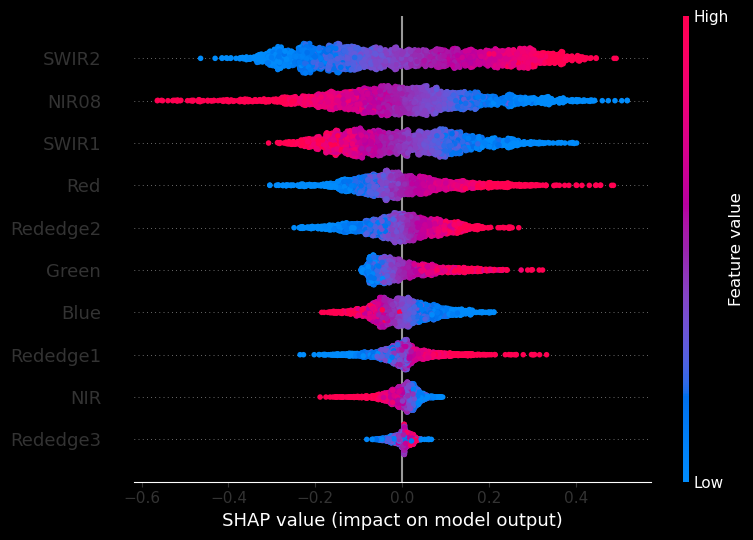

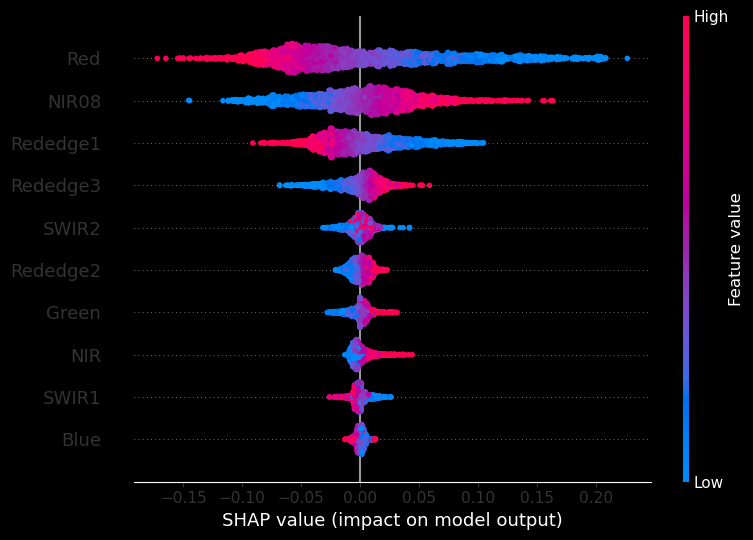

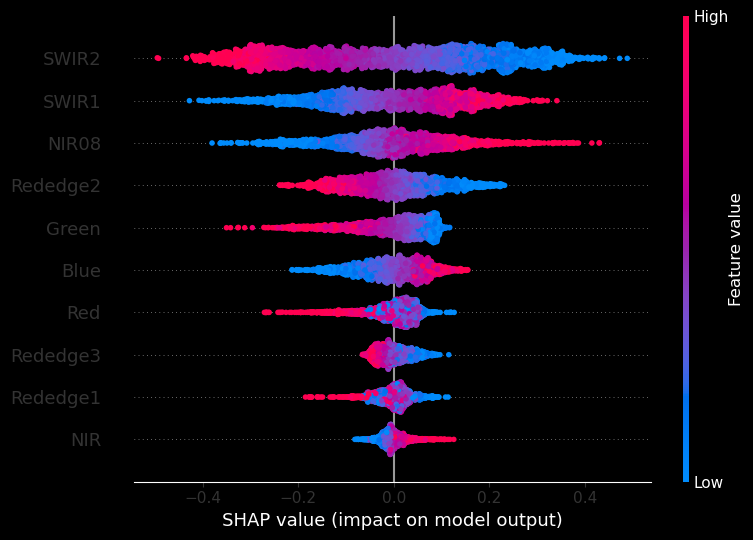

Mean SHAP Values for Bare Component:
Blue: 0.0521
Green: 0.0546
Red: 0.0844
Rededge1: 0.0437
Rededge2: 0.0662
Rededge3: 0.0150
NIR: 0.0255
NIR08: 0.1316
SWIR1: 0.1097
SWIR2: 0.1756

Mean SHAP Values for Green Component:
Blue: 0.0027
Green: 0.0055
Red: 0.0586
Rededge1: 0.0264
Rededge2: 0.0058
Rededge3: 0.0134
NIR: 0.0054
NIR08: 0.0355
SWIR1: 0.0044
SWIR2: 0.0061

Mean SHAP Values for Dry Component:
Blue: 0.0542
Green: 0.0617
Red: 0.0373
Rededge1: 0.0256
Rededge2: 0.0714
Rededge3: 0.0267
NIR: 0.0185
NIR08: 0.0910
SWIR1: 0.1178
SWIR2: 0.1837


In [39]:

# Assume that shap_values, train_dataset, and feature_names are defined as per your context.
feature_names = ['Blue','Green', 'Red', 'Rededge1', 'Rededge2', 'Rededge3', 'NIR', 'NIR08', 'SWIR1', 'SWIR2']

# Plot for the bare component
shap.summary_plot(shap_values[:, :, 0], train_dataset, feature_names=feature_names, title = 'Bare Component')

# Plot for the green component
shap.summary_plot(shap_values[:, :, 1], train_dataset, feature_names=feature_names, title = 'Green Component')

# Plot for the dry component
shap.summary_plot(shap_values[:, :, 2], train_dataset, feature_names=feature_names, title = 'Dry Component')


# Calculate the mean SHAP values for the bare component
mean_shap_bare = np.mean(np.abs(shap_values[:, :, 0]), axis=0)

# Calculate the mean SHAP values for the green component
mean_shap_green = np.mean(np.abs(shap_values[:, :, 1]), axis=0)

# Calculate the mean SHAP values for the dry component
mean_shap_dry = np.mean(np.abs(shap_values[:, :, 2]), axis=0)

# Display the results
print("Mean SHAP Values for Bare Component:")
for feature, value in zip(feature_names, mean_shap_bare):
    print(f"{feature}: {value:.4f}")

print("\nMean SHAP Values for Green Component:")
for feature, value in zip(feature_names, mean_shap_green):
    print(f"{feature}: {value:.4f}")

print("\nMean SHAP Values for Dry Component:")
for feature, value in zip(feature_names, mean_shap_dry):
    print(f"{feature}: {value:.4f}")



AOA Threshold: 0.14375805215837806


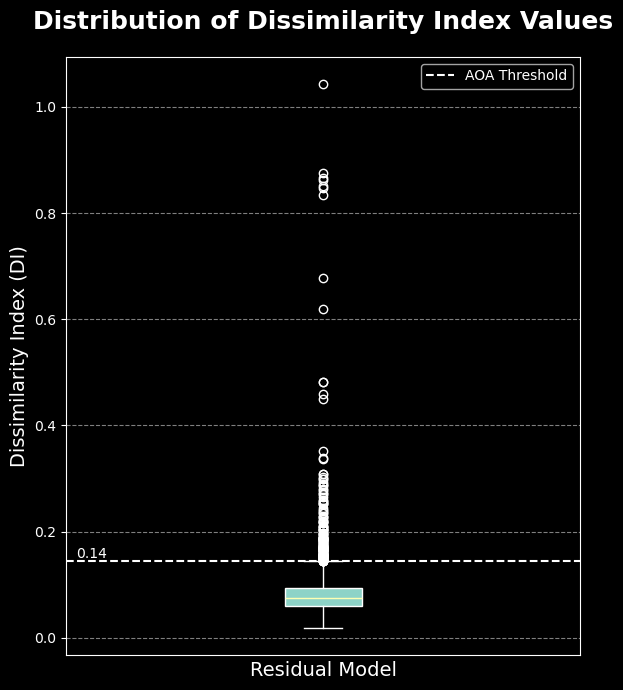

In [38]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import KFold
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt


def calculate_di(training_data, prediction_data, variable_importance):
    """
    Calculates the Dissimilarity Index (DI) for spatial predictions.

    Args:
        training_data (np.array): Array of training data with predictors (n_samples x n_predictors).
        prediction_data (np.array): Array of prediction data with predictors (n_predictions x n_predictors).
        variable_importance (np.array): Array of variable importance values from the trained model (n_predictors,).

    Returns:
        np.array: Array of DI values for each prediction point (n_predictions,).
    """

    # 1. Standardization of predictor variables
    scaler = StandardScaler()
    training_data_scaled = scaler.fit_transform(training_data)
    prediction_data_scaled = scaler.transform(prediction_data)

    # 2. Weighting of variables
    training_data_weighted = training_data_scaled * variable_importance
    prediction_data_weighted = prediction_data_scaled * variable_importance

    # 3. Calculate the average distance between all pairs of points in training data
    pairwise_distances = pdist(training_data_weighted, metric='euclidean')
    d = np.mean(pairwise_distances)  # Average distance in training data

    # 4. Calculate multivariate distances for prediction data
    knn = NearestNeighbors(n_neighbors=1, metric='euclidean')
    knn.fit(training_data_weighted)
    distances, _ = knn.kneighbors(prediction_data_weighted)

    # 5. Dissimilarity index
    di = distances.flatten() / d  # DI for each prediction point

    return di



def calculate_aoa_threshold(training_data, variable_importance, n_splits=5):
    """
    Calculates the Area of Applicability (AOA) threshold using cross-validation.

    Args:
        training_data (np.array): Array of training data (n_samples x n_predictors).
        variable_importance (np.array): Array of variable importance (n_predictors,).
        n_splits (int, optional): Number of cross-validation splits. Defaults to 5.

    Returns:
        float: The AOA threshold.
    """
    kf = KFold(n_splits=n_splits)
    cv_di_values = []

    for train_index, test_index in kf.split(training_data):
        X_train, X_test = training_data[train_index], training_data[test_index]

        di_values = calculate_di(X_train, X_test, variable_importance)
        cv_di_values.extend(di_values)

    # Outlier removal (using the upper whisker of a boxplot)
    q3 = np.percentile(cv_di_values, 75)
    iqr = np.percentile(cv_di_values, 75) - np.percentile(cv_di_values, 25)
    upper_whisker = q3 + 1.5 * iqr
    aoa_threshold = np.max([di for di in cv_di_values if di <= upper_whisker])

    return aoa_threshold, cv_di_values


# # Example usage
training_data = refData.copy()
# Get variable importance
variable_importance = mean_shap_green

# Calculate AOA threshold
aoa_threshold, cv_di_values = calculate_aoa_threshold(training_data, variable_importance, n_splits=5)
print("AOA Threshold:", aoa_threshold)




# Apply the dark background style globally
plt.style.use('dark_background')

# Create the figure and axis
plt.figure(figsize=(6, 7))

# Plot the boxplot without customizations
plt.boxplot(
    cv_di_values,
    patch_artist=True  # Keep this to make the boxes filled with color, matching the dark theme
)

# Add a horizontal line for the AOA threshold
plt.axhline(aoa_threshold, linestyle='--', label='AOA Threshold')

# Annotate the AOA threshold on the line
plt.text(0.55, aoa_threshold, f'{aoa_threshold:.2f}', ha='center', va='bottom')

# Customize labels and title (no need to set colors, inherits from style)
plt.xlabel('Residual Model', fontsize=14)
plt.ylabel('Dissimilarity Index (DI)', fontsize=14)
plt.title('Distribution of Dissimilarity Index Values', fontsize=18, weight='bold', pad=20)

# Set x-ticks to an empty list to remove them
plt.xticks(ticks=[])

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.5)

# Add legend
plt.legend(fontsize=10)

# Ensure layout is tight
plt.tight_layout()

# Save the plot
plt.savefig('green_aoa_threshold_residual.png', dpi=300)

# Display the plot
plt.show()


# Run FC

In [ ]:
import numpy as np
from rios import applier
from rios import cuiprogress
import tflite_runtime.interpreter as tflite

# This has to be run in Python <=3.11
# pip install tflite-runtime==2.14.0


"""
RIOS Function to apply the TF Lite model to the input data
"""


def _unmixfc(info,inputs,outputs,otherargs):   
    # Get the input array
    nbar = inputs.nbar
    # Get the shape of the input array
    inshape = nbar.shape
    # fmask is where all bands are 0
    fmask = np.all(nbar == 0, axis=0)
    # Flatten and floating point reflectance
    if np.all(fmask):
        # Make all the output 255 in all no data areas
        outputs.fc = np.ones((3,inshape[1],inshape[2]),dtype=np.uint8) * 255        
    else:
        nbar = np.reshape(nbar,(inshape[0],-1)).T / 10000.0
        # Predict using TFLite
        # Have to load the model each time when running in parallel as it cannot be pickled :(
        fcModel = tflite.Interpreter(model_path=TFLITE_MODEL)
        inputDetails = fcModel.get_input_details()
        outputDetails = fcModel.get_output_details()
        fcModel.resize_tensor_input(inputDetails[0]['index'], nbar.shape)
        fcModel.allocate_tensors()
        fcModel.set_tensor(inputDetails[0]['index'], nbar.astype(np.float32))
        fcModel.invoke()
        fcLayers = fcModel.get_tensor(outputDetails[0]['index'])
        # Clip Output
        fcLayers = np.clip(fcLayers.T,0,2)
        # Scale Fractions so they sum to one
        fcLayerSum = fcLayers.sum(axis=0) + np.finfo('float32').eps
        outputFC = np.round(100 * fcLayers/fcLayerSum, 0)
        # Write the FC Output
        outputFC = np.reshape(outputFC,(3,inshape[1],inshape[2]))
        # Correct noData
        outputFC[:,fmask] = 255
        outputs.fc =  outputFC.astype(np.uint8)

"""
Function to apply the TF Lite model to unmix Sentinel 2 data
"""
      
def unmixfc(infile,outfile):
    infiles = applier.FilenameAssociations()
    outfiles = applier.FilenameAssociations()

    infiles.nbar = infile
    outfiles.fc = outfile

    otherargs = applier.OtherInputs()
    # Have to load the model in _unmixfc when running in parallel as it cannot be pickled :(
    # otherargs.fcModel = tflite.Interpreter(model_path=TFLITE_MODEL)

    controls = applier.ApplierControls()
    controls.progress = cuiprogress.CUIProgressBar()
    controls.windowxsize = 512
    controls.windowysize = 512
    controls.setStatsIgnore(255)
    
    # FIXME: Using OLD RIOS API
    controls.setNumThreads(4)
    # FIXME: Using OLD RIOS API
    controls.setJobManagerType('multiprocessing')

    controls.setOutputDriverName("GTIFF")
    controls.setCreationOptions(["COMPRESS=DEFLATE",
                                 "ZLEVEL=1",
                                 "BIGTIFF=YES",
                                 "TILED=YES",
                                 "INTERLEAVE=BAND",
                                 "NUM_THREADS=ALL_CPUS",
                                 "BLOCKXSIZE=512",
                                 "BLOCKYSIZE=512"])

    applier.apply(_unmixfc, infiles, outfiles, otherargs, controls=controls)

TFLITE_MODEL = "s2_fc_model.tflite" 


if __name__ == "__main__":
    # import sys
    # main(sys.argv[1],sys.argv[2])
    # Connect to the seasonal surface reflectance
    inFile = 'median_nbar_aus_20250202_a0_r80m.tif'
    outFile = 'median_fc_aus_20250202_a0_r80m.tif'
    unmixfc(inFile,outFile)


### FC Output from this model
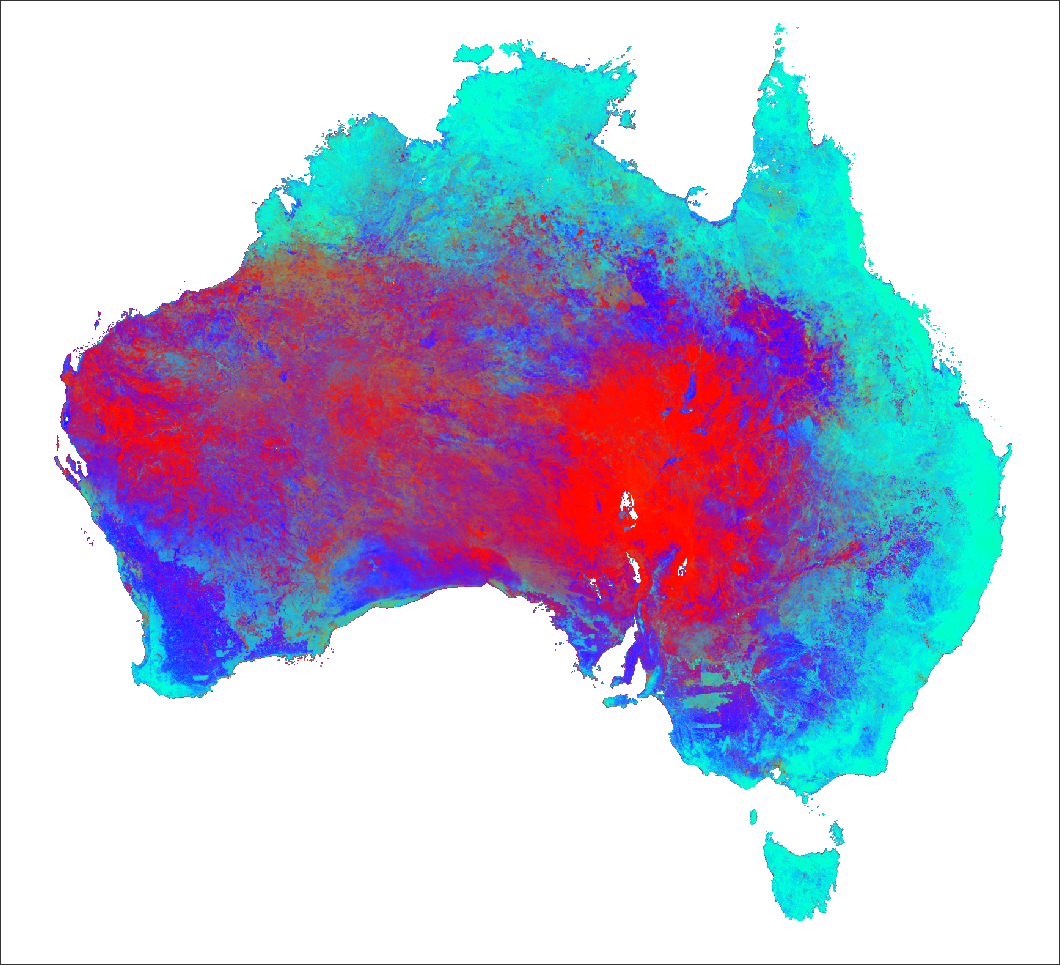

## FDC Output from old landsat model
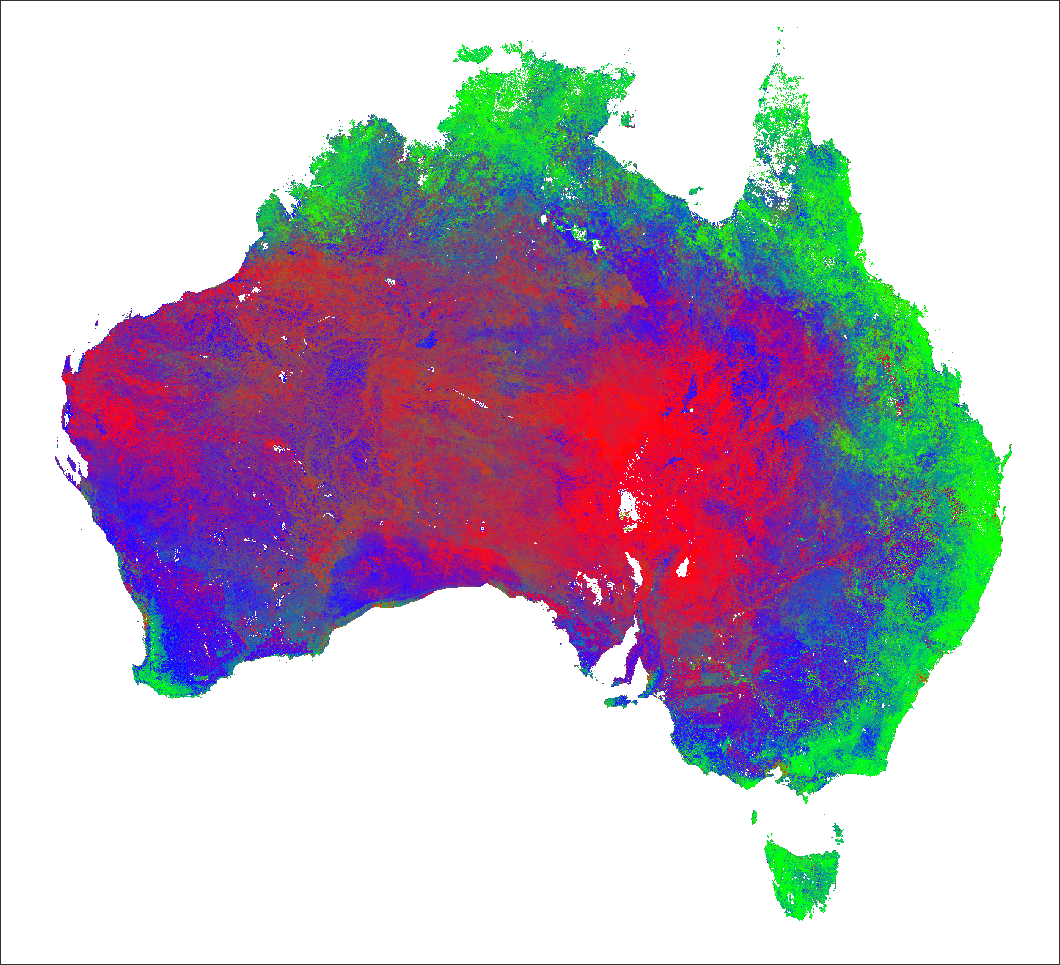